# Quantum Kernel Training for Machine Learning Applications

In this tutorial, we will train a quantum kernel on a labeled dataset for a machine learning application. To illustrate the basic steps, we will use Quantum Kernel Alignment (QKA) for a binary classification task. QKA is a technique that iteratively adapts a parametrized quantum kernel to a dataset while converging to the maximum SVM margin. More information about QKA can be found in the preprint, ["Covariant quantum kernels for data with group structure."](https://arxiv.org/abs/2105.03406)


The entry point to training a quantum kernel is the `QuantumKernelTrainer` class. The basic steps are:

1. Prepare the dataset
2. Define the quantum feature map
3. Set up an instance of `TrainableKernel` and `QuantumKernelTrainer` objects
4. Use the `QuantumKernelTrainer.fit` method to train the kernel parameters on the dataset
5. Pass the trained quantum kernel to a machine learning model

### Import Local, External, and Qiskit Packages and define a callback class for our optimizer

In [1]:
# External imports
from pylab import cm
from sklearn import metrics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import zz_feature_map
from qiskit_machine_learning.optimizers import SPSA
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data


class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

### Prepare the Dataset

In this guide, we will use Qiskit Machine Learning's `ad_hoc.py` dataset to demonstrate the kernel training process. See the documentation [here](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.datasets.ad_hoc_data.html).

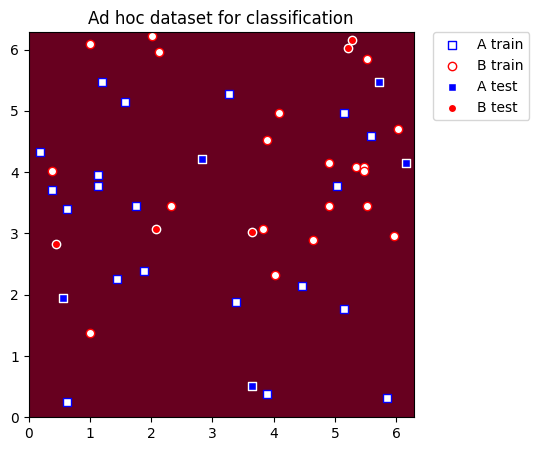

In [2]:
adhoc_dimension = 2
X_train, y_train, X_test, y_test, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    X_train[np.where(y_train[:] == 0), 0],
    X_train[np.where(y_train[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    X_train[np.where(y_train[:] == 1), 0],
    X_train[np.where(y_train[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    X_test[np.where(y_test[:] == 0), 0],
    X_test[np.where(y_test[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    X_test[np.where(y_test[:] == 1), 0],
    X_test[np.where(y_test[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

plt.show()

### Define the Quantum Feature Map

Next, we set up the quantum feature map, which encodes classical data into the quantum state space. Here, we use a `QuantumCircuit` to set up a trainable rotation layer and a `zz_feature_map` from `Qiskit` to represent the input data.

In [3]:
# Create a rotational layer to train. We will rotate each qubit the same amount.
training_params = ParameterVector("θ", 1)
fm0 = QuantumCircuit(2)
fm0.ry(training_params[0], 0)
fm0.ry(training_params[0], 1)

# Use ZZFeatureMap to represent input data
fm1 = zz_feature_map(2)

# Create the feature map, composed of our two circuits
fm = fm0.compose(fm1)

print(circuit_drawer(fm))
print(f"Trainable parameters: {training_params}")

     ┌──────────┐┌───┐┌───────────┐                                          »
q_0: ┤ Ry(θ[0]) ├┤ H ├┤ P(2*x[0]) ├──■────────────────────────────────────■──»
     ├──────────┤├───┤├───────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐»
q_1: ┤ Ry(θ[0]) ├┤ H ├┤ P(2*x[1]) ├┤ X ├┤ P((-π + x[0])*(-π + x[1])*2) ├┤ X ├»
     └──────────┘└───┘└───────────┘└───┘└──────────────────────────────┘└───┘»
«     ┌───┐┌───────────┐                                          
«q_0: ┤ H ├┤ P(2*x[0]) ├──■────────────────────────────────────■──
«     ├───┤├───────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐
«q_1: ┤ H ├┤ P(2*x[1]) ├┤ X ├┤ P((-π + x[0])*(-π + x[1])*2) ├┤ X ├
«     └───┘└───────────┘└───┘└──────────────────────────────┘└───┘
Trainable parameters: θ, ['θ[0]']


### Set Up the Quantum Kernel and Quantum Kernel Trainer

To train the quantum kernel, we will use an instance of `TrainableFidelityQuantumKernel` (holds the feature map and its parameters) and `QuantumKernelTrainer` (manages the training process).

We will train using the Quantum Kernel Alignment technique by selecting the kernel loss function, `SVCLoss`, as input to the `QuantumKernelTrainer`. Since this is a Qiskit-supported loss, we can use the string, `"svc_loss"`; however, note that default settings are used when passing the loss as a string. For custom settings, instantiate explicitly with the desired options, and pass the `KernelLoss` object to the `QuantumKernelTrainer`.

We will select SPSA as the optimizer and initialize the trainable parameter with the `initial_point` argument. Note: The length of the list passed as the `initial_point` argument must equal the number of trainable parameters in the feature map.

In [4]:
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)

# Instantiate quantum kernel
quant_kernel = TrainableFidelityQuantumKernel(
    fidelity=fidelity, feature_map=fm, training_parameters=training_params
)

# Set up the optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
)

### Train the Quantum Kernel

To train the quantum kernel on the dataset (samples and labels), we call the `fit` method of `QuantumKernelTrainer`.

The output of `QuantumKernelTrainer.fit` is a `QuantumKernelTrainerResult` object. The results object contains the following class fields:

 - `optimal_parameters`: A dictionary containing {parameter: optimal value} pairs
 - `optimal_point`: The optimal parameter value found in training
 - `optimal_value`: The value of the loss function at the optimal point
 - `optimizer_evals`: The number of evaluations performed by the optimizer
 - `optimizer_time`: The amount of time taken to perform optimization
 - `quantum_kernel`: A `TrainableKernel` object with optimal values bound to the feature map

In [5]:
# Train the kernel using QKT directly
qka_results = qkt.fit(X_train, y_train)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

{   'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): np.float64(2.027588764259752)},
    'optimal_point': array([2.02758876]),
    'optimal_value': np.float64(16.49276374187851),
    'optimizer_evals': 30,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7f86c4218940>}


### Fit and Test the Model

We can pass the trained quantum kernel to a machine learning model, then fit the model and test on new data. Here, we will use Qiskit Machine Learning's `QSVC` for classification.

In [6]:
# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.9


### Visualize the Kernel Training Process

From the callback data, we can plot how the loss evolves during the training process. We see it converges rapidly and reaches high test accuracy on this dataset with our choice of inputs.

We can also display the final kernel matrix, which is a measure of similarity between the training samples.

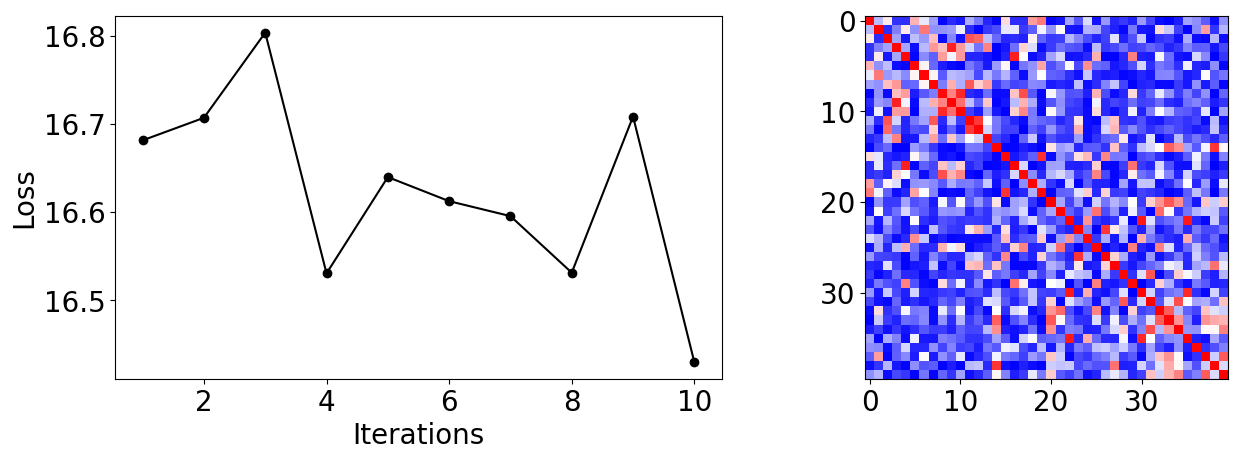

In [7]:
plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=matplotlib.colormaps["bwr"])
fig.tight_layout()
plt.show()

In [8]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright